# Summary

This notebook compares the average performance of the convex combination with other models over several executions.

It uses the Sine high speed high severity dataset.

# Libraries

In [1]:
import sys

sys.path.append("../")

from src.convex_combination import ConvexCombination
from src.ddd import DDD
from src.online_bagging import OnlineBagging
from src.drift_detector import DriftDetectorWrapper

# Execution

1. First execute the main cell once with only one execution to create the variables that track the number of models and metrics. The number of executions is controlled by the variable *total_number_executions*.
2. Then execute the next cell that creates the lists for tracking the metrics average.
3. Finally the main cell can be executed again with the desired number of executions.

In [ ]:
total_number_executions = 10

# Run once with this value for creating the global metrics lists
# total_number_executions = 1

In [ ]:
# Main cell

# Sine high speed high severity
from river.datasets import synth
from itertools import chain
from river import metrics, utils
from river import preprocessing, optim, linear_model
from river import tree, drift

for execution_number in range(10):
    class_list = [0, 1]
    n_samples = 10000

    stream1 = synth.Sine(classification_function=2, balance_classes=True, has_noise=True)
    stream2 = synth.Sine(classification_function=3, balance_classes=True, has_noise=True)
    stream3 = synth.Sine(classification_function=2, balance_classes=True, has_noise=True)

    dataset = chain(stream1.take(3000), stream2.take(3000), stream3.take(4000))


    def get_logis_reg():
        return preprocessing.StandardScaler() | linear_model.LogisticRegression(optimizer=optim.SGD(0.1))


    p_ht = {"delta": 1e-07, "max_depth": 25}
    p_drift_detector_ddd = {"alpha": 0.90, "beta": 0.85}
    p_drift_detector_convex = {"alpha": 0.90, "beta": 0.85}
    p_convex = {"gamma": 0.9, "mu": 1, "lambda_error": 0.95, "store_metrics": True}

    p_slow_ensemble = {
        "base_classifier_class": tree.HoeffdingTreeClassifier,
        "n_classifiers": 10,
        "lambda_diversity": 1,
        "p_classifiers": p_ht,
        "class_list": class_list,
    }
    p_fast_ensemble = {
        "base_classifier_class": get_logis_reg,
        "n_classifiers": 10,
        "lambda_diversity": 1,
        "p_classifiers": {},
        "class_list": class_list,
    }
    slow_learner = DriftDetectorWrapper(
        OnlineBagging(**p_slow_ensemble),
        drift.binary.EDDM(**p_drift_detector_convex),
        train_in_background=False,
    )
    fast_learner = OnlineBagging(**p_fast_ensemble)
    convex_model = ConvexCombination(fast_learner, slow_learner, p_convex=p_convex, class_list=class_list)

    # DDD model
    p_low_ensemble = {
        "base_classifier_class": tree.HoeffdingTreeClassifier,
        "n_classifiers": 10,
        "lambda_diversity": 1,
        "p_classifiers": p_ht,
        "class_list": class_list,
    }
    p_high_ensemble = {
        "base_classifier_class": tree.HoeffdingTreeClassifier,
        "n_classifiers": 10,
        "lambda_diversity": 0.05,
        "p_classifiers": p_ht,
        "class_list": class_list,
    }
    ddd_model = DDD(
        drift_detector=drift.binary.EDDM(**p_drift_detector_ddd),
        p_low_ensemble=p_low_ensemble,
        p_high_ensemble=p_high_ensemble,
        W=1,
        class_list=class_list,
    )

    # EDDM
    eddm_model = DriftDetectorWrapper(
        OnlineBagging(**p_low_ensemble),
        drift.binary.EDDM(**p_drift_detector_convex),
        train_in_background=True,
    )

    # Base models
    ht_model = tree.HoeffdingTreeClassifier(**p_ht)
    lg_model = preprocessing.StandardScaler() | linear_model.LogisticRegression(optimizer=optim.SGD(0.1))

    model_list = [convex_model, ddd_model, eddm_model, ht_model, lg_model]
    n_models = len(model_list)


    # Lists for storing predictions convex
    y_true_list = []
    y_pred_list = []

    for i in range(n_models):
        y_pred_list.append([])


    # Generic loop for convex storing predictions
    for idx, (x, y) in enumerate(dataset):
        y_true_list.append(y)
        for i in range(n_models):
            # Predict and update the model
            y_pred = model_list[i].predict_one(x)
            model_list[i].learn_one(x, y)
            y_pred_list[i].append(y_pred)


    # Metrics
    metrics_list = []
    metrics_cum_list = []

    for i in range(n_models):
        model_metrics = [utils.Rolling(metrics.Accuracy(), 250), utils.Rolling(metrics.Accuracy(), 1000)]
        n_metrics = len(model_metrics)

        metrics_list.append(model_metrics)
        metrics_cum_list.append([[] for _ in range(n_metrics)])


    # Convert predictions to metrics
    for i in range(n_models):
        for idx in range(len(y_true_list)):
            y = y_true_list[idx]
            y_pred = y_pred_list[i][idx]
            # Update the metrics
            for j in range(n_metrics):
                try:
                    metrics_list[i][j].update(y, y_pred)
                except:
                    metrics_list[i][j].update(y, class_list[0])
                    print("ERROR")
                metrics_cum_list[i][j].append(metrics_list[i][j].get())


    # Update metrics average
    metric_n = 1

    for i in range(n_models):
        other_idx = 0
        for idx in range(n_samples):
            metrics_avg_list[i][other_idx].update(metrics_cum_list[i][metric_n][idx])
            metrics_final_list[i][other_idx] = metrics_avg_list[i][other_idx].get()
            other_idx += 1
    
    print(f"Finished execution {execution_number}")

In [3]:
# Create metrics average
from river import stats

reset_global_metrics = False

if reset_global_metrics:
    n_executions = 0
    metrics_avg_list = []
    metrics_final_list = []
    for i in range(n_models):
        metrics_avg_list.append([])
        metrics_final_list.append([])
        for idx in range(1, n_samples + 1):
            metrics_avg_list[i].append(stats.Mean())
            metrics_final_list[i].append(0)

# Plotting

In [ ]:
# Average plot
from datetime import datetime
import matplotlib.pyplot as plt

metric_n = 1

fig, ax = plt.subplots()
ax.plot(range(1, n_samples + 1), metrics_final_list[4], ":", color="tab:olive", label=f"Base LG")
ax.plot(range(1, n_samples + 1), metrics_final_list[3], ":", color="tab:cyan", label=f"Base HT")
ax.plot(range(1, n_samples + 1), metrics_final_list[2], "-", color="tab:orange", label=f"EDDM")
ax.plot(range(1, n_samples + 1), metrics_final_list[1], "-", color="tab:blue", label=f"DDD")
ax.plot(range(1, n_samples + 1), metrics_final_list[0], "-", color="k", label=f"Convex")
ax.set_xlim(0, n_samples)
ax.set_ylim(0.5, 1)
ax.set_xlabel("Time step")
ax.set_ylabel("Accuracy")
# ax.set_title("Graph title")
ax.legend(loc="lower left")
ax.grid()
print(f"Executed {datetime.now()}")

In [ ]:
# Single plot
from datetime import datetime
import matplotlib.pyplot as plt

metric_n = 1

fig, ax = plt.subplots()
ax.plot(range(1, n_samples + 1), metrics_cum_list[4][metric_n], ":", color="tab:olive", label=f"Base LG")
ax.plot(range(1, n_samples + 1), metrics_cum_list[3][metric_n], ":", color="tab:cyan", label=f"Base HT")
ax.plot(range(1, n_samples + 1), metrics_cum_list[2][metric_n], "-", color="tab:orange", label=f"EDDM")
ax.plot(range(1, n_samples + 1), metrics_cum_list[1][metric_n], "-", color="tab:blue", label=f"DDD")
ax.plot(range(1, n_samples + 1), metrics_cum_list[0][metric_n], "-", color="k", label=f"Convex")
ax.set_xlim(0, n_samples)
ax.set_ylim(0.5, 1)
ax.set_xlabel("Time step")
ax.set_ylabel("Accuracy")
# ax.set_title("Graph title")
ax.legend(loc="lower left")
ax.grid()
print(f"Executed {datetime.now()}")

## Past plots

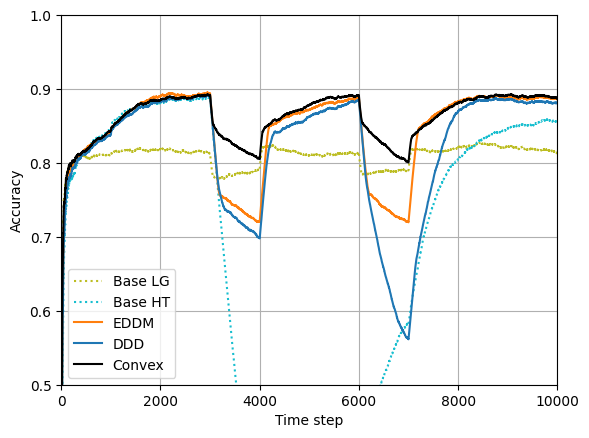

In [ ]:
# Final average plot
from datetime import datetime
import matplotlib.pyplot as plt

metric_n = 1

fig, ax = plt.subplots()
ax.plot(range(1, n_samples + 1), metrics_final_list[4], ":", color="tab:olive", label=f"Base LG")
ax.plot(range(1, n_samples + 1), metrics_final_list[3], ":", color="tab:cyan", label=f"Base HT")
ax.plot(range(1, n_samples + 1), metrics_final_list[2], "-", color="tab:orange", label=f"EDDM")
ax.plot(range(1, n_samples + 1), metrics_final_list[1], "-", color="tab:blue", label=f"DDD")
ax.plot(range(1, n_samples + 1), metrics_final_list[0], "-", color="k", label=f"Convex")
ax.set_xlim(0, n_samples)
ax.set_ylim(0.5, 1)
ax.set_xlabel("Time step")
ax.set_ylabel("Accuracy")
# ax.set_title("Graph title")
ax.legend(loc="lower left")
ax.grid()
print(f"Executed {datetime.now()}")

Executed 2023-09-02 14:00:58.748371


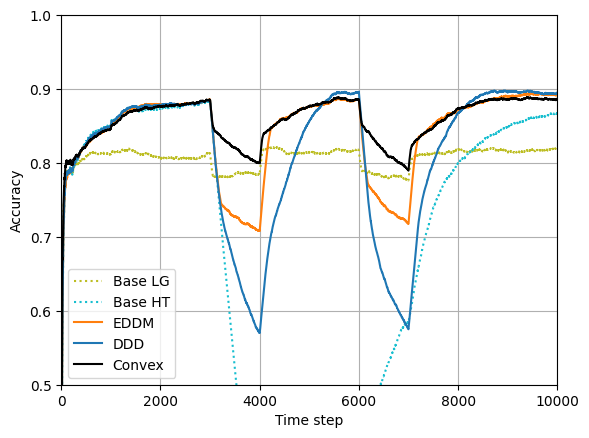

In [9]:
# Average plot with 0.1 high div
from datetime import datetime
import matplotlib.pyplot as plt

metric_n = 1

fig, ax = plt.subplots()
ax.plot(range(1, n_samples + 1), metrics_final_list[4], ":", color="tab:olive", label=f"Base LG")
ax.plot(range(1, n_samples + 1), metrics_final_list[3], ":", color="tab:cyan", label=f"Base HT")
ax.plot(range(1, n_samples + 1), metrics_final_list[2], "-", color="tab:orange", label=f"EDDM")
ax.plot(range(1, n_samples + 1), metrics_final_list[1], "-", color="tab:blue", label=f"DDD")
ax.plot(range(1, n_samples + 1), metrics_final_list[0], "-", color="k", label=f"Convex")
ax.set_xlim(0, n_samples)
ax.set_ylim(0.5, 1)
ax.set_xlabel("Time step")
ax.set_ylabel("Accuracy")
# ax.set_title("Graph title")
ax.legend(loc="lower left")
ax.grid()
print(f"Executed {datetime.now()}")

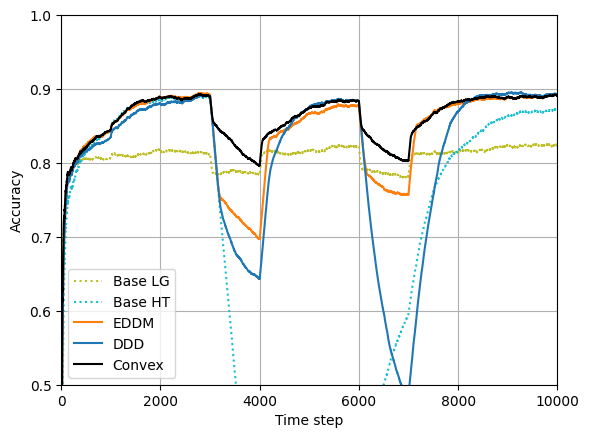

In [11]:
# Average plot with 0.1 high div
from datetime import datetime
import matplotlib.pyplot as plt

metric_n = 1

fig, ax = plt.subplots()
ax.plot(range(1, n_samples + 1), metrics_final_list[4], ":", color="tab:olive", label=f"Base LG")
ax.plot(range(1, n_samples + 1), metrics_final_list[3], ":", color="tab:cyan", label=f"Base HT")
ax.plot(range(1, n_samples + 1), metrics_final_list[2], "-", color="tab:orange", label=f"EDDM")
ax.plot(range(1, n_samples + 1), metrics_final_list[1], "-", color="tab:blue", label=f"DDD")
ax.plot(range(1, n_samples + 1), metrics_final_list[0], "-", color="k", label=f"Convex")
ax.set_xlim(0, n_samples)
ax.set_ylim(0.5, 1)
ax.set_xlabel("Time step")
ax.set_ylabel("Accuracy")
# ax.set_title("Graph title")
ax.legend(loc="lower left")
ax.grid()
print(f"Executed {datetime.now()}")

Executed 2023-09-02 13:19:46.969183


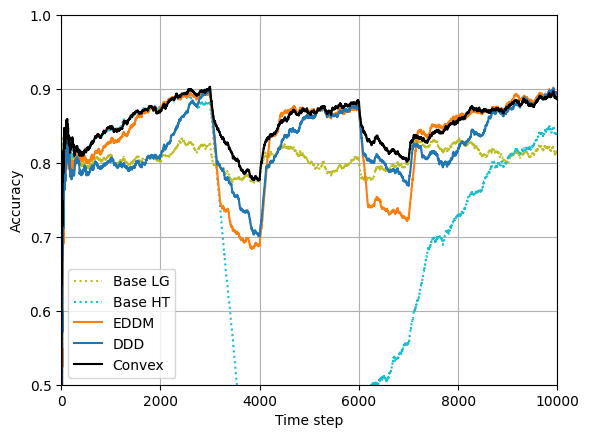

In [ ]:
# Single plot with good DDD performance
from datetime import datetime
import matplotlib.pyplot as plt

metric_n = 1

fig, ax = plt.subplots()
ax.plot(range(1, n_samples + 1), metrics_cum_list[4][metric_n], ":", color="tab:olive", label=f"Base LG")
ax.plot(range(1, n_samples + 1), metrics_cum_list[3][metric_n], ":", color="tab:cyan", label=f"Base HT")
ax.plot(range(1, n_samples + 1), metrics_cum_list[2][metric_n], "-", color="tab:orange", label=f"EDDM")
ax.plot(range(1, n_samples + 1), metrics_cum_list[1][metric_n], "-", color="tab:blue", label=f"DDD")
ax.plot(range(1, n_samples + 1), metrics_cum_list[0][metric_n], "-", color="k", label=f"Convex")
ax.set_xlim(0, n_samples)
ax.set_ylim(0.5, 1)
ax.set_xlabel("Time step")
ax.set_ylabel("Accuracy")
# ax.set_title("Graph title")
ax.legend(loc="lower left")
ax.grid()
print(f"Executed {datetime.now()}")

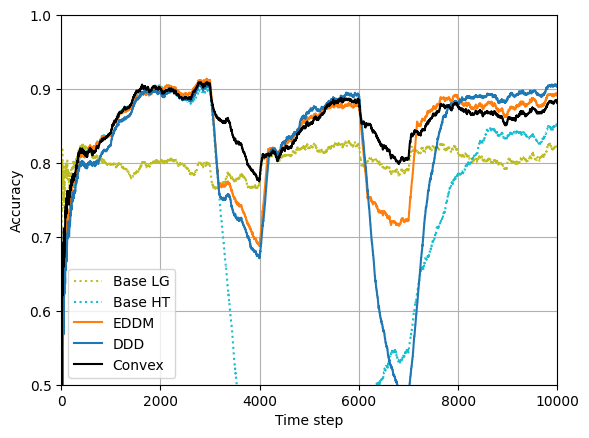

In [10]:
# Single plot with very bad DDD performance on second drift
from datetime import datetime
import matplotlib.pyplot as plt

metric_n = 1

fig, ax = plt.subplots()
ax.plot(range(1, n_samples + 1), metrics_cum_list[4][metric_n], ":", color="tab:olive", label=f"Base LG")
ax.plot(range(1, n_samples + 1), metrics_cum_list[3][metric_n], ":", color="tab:cyan", label=f"Base HT")
ax.plot(range(1, n_samples + 1), metrics_cum_list[2][metric_n], "-", color="tab:orange", label=f"EDDM")
ax.plot(range(1, n_samples + 1), metrics_cum_list[1][metric_n], "-", color="tab:blue", label=f"DDD")
ax.plot(range(1, n_samples + 1), metrics_cum_list[0][metric_n], "-", color="k", label=f"Convex")
ax.set_xlim(0, n_samples)
ax.set_ylim(0.5, 1)
ax.set_xlabel("Time step")
ax.set_ylabel("Accuracy")
# ax.set_title("Graph title")
ax.legend(loc="lower left")
ax.grid()
print(f"Executed {datetime.now()}")